# Steady One-Dimensional Laminar Premixed Flame

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 8 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 19 February 2020.

The objective of this tutorial is to review basic aspects of steady one-dimensional laminar premixed flames, and to show how to simulate a steady one-dimensional adiabatic laminar premixed flame propagating through an ideal-gas mixture using Cantera. Laminar flame speeds computed using a realistic reaction mechanism and transport properties are compared with those obtained using an empirical flame-speed correlation. We will use the thermodynamic properties, reaction mechanism, and molecular transport properties that are included in gri30.cti.

For the figure in Section 1 below to display properly, the file "1D_premixed_flame.png" that is provided with this Notebook must be placed in a folder or directory named "images" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place.

The reader should be familiar with the material in the Chapter 7 Notebooks before working through this Notebook.

## 1. Physical configuration

A schematic of the configuration is shown below. (Note: For the figure to display properly, the file "1D_premixed_flame.png" must be placed in a folder or directory named "images" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place.)

<img src="images/1D_premixed_flame.png" alt="Schematic of a premixed laminar hlame" style="width: 500px;"/>

The *flame* is a thin zone across which the temperature increases from $T_u$ to $T_b$, and the composition changes from that of the reactant (fuel + oxidizer) mixture to that of the product mixture. A defining characteristic of a flame (a *deflagration*) is that the pressure change across a flame is small: $ \vert ( P_u - P_b ) \vert / P_u \ll 1 $, where $P_u$ and $P_b$ are the unburned-reactants and the burned-products pressures, respectively. This is in contrast to a *detonation*, across which the pressure change is large. Detonations will be discussed in Chapter 16 of Turns 4th ed. Neglecting radiative heat losses, it follows that for a flame, the product temperature and composition correspond (to a good approximation) to the constant-pressure adiabatic equilibrium values for the given reactant mixture temperature, pressure, and composition.

We adopt a reference frame that is attached to the flame. In that frame, the system is one-dimensional and steady, and the speed at which the unburned reactants approach the stationary flame is, by definition, the *laminar flame speed* or the *laminar burning velocity*, denoted as $S_L$. The mass flux (kg/m^2-s) through the flame (the mass rate at which reactants are converted to products, per unit surface area of flame) is constant and is equal to $ \rho _ u S_L $, where $ \rho_u $ is the mass density of the unburned reactant mixture. It then follows that the speed at which the burned products leave the flame is $ S_L \rho_u / \rho _ b$, where $\rho_b$ is the mass density of the burned product mixture. Neglecting the small pressure change across the flame, and also the change in mixture molecular weight from unburned reactants to burned products (often a reasonable first approximation when the oxidizer is air - see tutorial Notebook 2_1_Mass_moles_molecular_weights_mixtures), the density ratio across the flame is approximately equal to the inverse of the temperature ratio across the flame. The flame thickness $\delta_L$ can be defined formally in various ways, in terms of the temperature profile, species profiles, or heat-release-rate profile through the flame. For stoichiometric hydrocarbon-air reactant mixtures at ambient temperature (300 K) and pressure (1 atm), typical values are $S_L \approx 0.5 $ m/s, $T_b/T_u \approx 7$, and $\delta_L \approx 0.1$ mm, where $\delta_L$ is based on the heat-release-rate profile (i.e., the thickness of the region in which most of the conversion from chemical to sensible enthalpy takes place).

The flame speed is a characteristic of the unburned reactant mixture, and depends on the unburned-gas temperature, pressure, and composition. It is determined by a balance between the rate of heat release in the flame (conversion of chemical enthalpy to sensible enthalpy) and the rate of molecular transport of heat (conduction) from the high-temperature burned gas to preheat the unburned reactants to a temperature that is sufficiently high that chemical reactions can start to occur and become self-sustaining. Thus in contrast to the homogeneous systems considered through Chapter 6 of Turns 4th ed., molecular transport properties of the reacting mixture are needed, in addition to thermodynamic properties and a reaction mechanism. Molecular tranport properties were discussed in tutorial Notebook 7_1_Molecular_transport_properties.

The dependencies of the flame speed $S_L$, and of the flame thickness $ \delta _ L$, on reactant temperature, pressure, and composition are discussed in Chapter 8 of Turns 4th ed. The simplified analysis presented there captures the essential underlying physical processes. It reveals that the flame speed is proportional to the square root of the product of a chemical reaction rate $ \dot \omega $ (e.g., a global reaction rate) and a molecular diffusivity $ D $ (equal diffusivities for momentum, heat, and species are assumed in the simplified analysis), and that the flame thickness is proportional to the square root of the ratio of $D$ to $ \dot \omega $:

$$ S_L \propto \sqrt {\dot \omega D} \ , \ \delta _ L \propto \sqrt {D / \dot \omega} $$

For a more detailed analysis, realistic thermodynamic and transport properties, and a realistic reaction mechanism, are needed. The governing equations for a detailed analysis also are given in Chapter 8.

## 2. Cantera model

As was the case for the homogeneous systems considered in Chapter 6, we do not need to explicitly provide the governing equations to Cantera. Rather, we use predefined objects that essentially do that for us. 

In [1]:
# import modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time

# print Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define the gas mixture
# here we use the thermodynamic properties, reaction mechanism, and molecular transport properties from gri30.cti
gas = ct.Solution('gri30.cti')

In [3]:
# specify the unburned reactant mixture thermochemical state
# here we consider a stoichiometric mixture of CH4 and air at ambient pressure and temperature
T_u  = 300.       # (K)
P_u  = ct.one_atm # (Pa)
fuel = 'CH4'
air  = {'O2':1.0, 'N2':3.76}
phi  = 1.0

gas.TP = T_u, P_u
gas.set_equivalence_ratio(phi, fuel, air)

# print the state of the unburned reactants
gas()


  gri30:

       temperature             300  K
          pressure          101325  Pa
           density         1.12252  kg/m^3
  mean mol. weight         27.6332  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -2.5459e+05       -7.035e+06     J
   internal energy     -3.4486e+05       -9.529e+06     J
           entropy          7247.8        2.003e+05     J/K
    Gibbs function     -2.4289e+06       -6.712e+07     J
 heat capacity c_p          1077.3        2.977e+04     J/K
 heat capacity c_v          776.45        2.146e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.190114         0.220149         -26.3339
               CH4       0.095057        0.0551863         -54.6761
                N2       0.714829         0.724665         -23.3688
     [  +50 minor]        

We will use Cantera's [`FreeFlame()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#freeflame) object to define the flame.

In [4]:
# let's see what "FreeFlame" does
help(ct.FreeFlame)

Help on class FreeFlame in module cantera.onedim:

class FreeFlame(FlameBase)
 |  FreeFlame(gas, grid=None, width=None)
 |  
 |  A freely-propagating flat flame.
 |  
 |  Method resolution order:
 |      FreeFlame
 |      FlameBase
 |      cantera._cantera.Sim1D
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, gas, grid=None, width=None)
 |      A domain of type IdealGasFlow named 'flame' will be created to represent
 |      the flame and set to free flow. The three domains comprising the stack
 |      are stored as ``self.inlet``, ``self.flame``, and ``self.outlet``.
 |      
 |      :param grid:
 |          A list of points to be used as the initial grid. Not recommended
 |          unless solving only on a fixed grid; Use the `width` parameter
 |          instead.
 |      :param width:
 |          Defines a grid on the interval [0, width] with internal points
 |          determined automatically by the solver.
 |  
 |  get_flame_speed_reaction_sensitivi

This detailed information may be of limited utility for a novice user. The example that follows may be more instructive. This example can be used as a starting point for computing steady one-dimensional laminar premixed flames using Cantera. 

The basic solution strategy is to solve the governing equations (as given in Chapter 8) using a finite-difference method on a one-dimensional grid that discretizes the spatial coordinate ($x$, say) in which the temperature and composition vary through the flame into small subintervals $ \Delta x $, where $\Delta x$ is not necessarily uniform. In general, the grid needs to be finer (smaller $\Delta x$) in regions where the solution (e.g., temperature and species composition) varies rapidly as a function of $x$. Because we don't know ahead of time how thick the flame will be, or how best to distribute the grid points in $x$, an adaptive solution method is used, where the width of the computational domain and the distribution of grid points in $x$ varies as the numerical solution proceeds. And although a steady-state solution is sought, the algorithm that is used includes marching in time to reach the steady-state. The numerical solution continues until either: 1) a converged solution is found that satisfies the governing equations to within user-specified accuracy requirements; or 2) the solution fails to converge, and terminates with an error.

Key ingredients required to initialize the numerical solution, then, are an initial computational domain width, an initial spatial distribution of grid points, initial spatial profiles of temperature and composition (recall that the pressure is assumed to be constant), and numerical parameters to select the solution algorithm and to control the grid refinement and solution accuracy. In most cases, it will be sufficient to accept the defaults that are built in to `FreeFlame()`.

Further information about what is happening as the numerical solution proceeds is provided in the comments for the example that follows. In this example, we provide just three basic pieces of information to the solver, in addition to the thermochemical state of the unburned reactants: the initial width of the computational domain, some numerical parameters that control grid refinement (we accept the default values for all other numerical parameters, including convergence criteria), and the level of output that we want to see as the numerical solution proceeds.

In [5]:
# specify the initial size ("width") of the 1D computational domain
# the width of the domain will be extended automatically, if needed, over the course of the numerical simulation
width = 0.015 # (m)

# create the flame object by filling the computational domain with the desired gas mixture
flame = ct.FreeFlame(gas, width=width)

# specify numerical parameters used to control local grid refinement
# by default, the code will start with a coarse uniform grid
# it will then successively refine the grid, inserting more grid points locally in regions where the solution varies
#   rapidly in space
# some prior experience can be helpful to determine appropriate values
# you can experiment to see what happens if you change these values
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# specify the level of output desired
# loglevel = 1 is appropriate for current purposes
# you can decrease/increase the value of loglevel to see less/more detailed output
# valid values for loglevel are 0 (no output) to 5 (most detailed output)
loglevel = 1

In [6]:
# list all available attributes of "flame": that is, of a Cantera "FreeFlame" object
dir(flame)

['L',
 'P',
 'T',
 'V',
 'X',
 'Y',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_get_indices',
 '_get_initial_solution',
 '_interrupt',
 '_steady_callback',
 '_time_step_callback',
 'chemical_potentials',
 'clear_stats',
 'concentrations',
 'cp',
 'cp_mass',
 'cp_mole',
 'creation_rates',
 'cv',
 'cv_mass',
 'cv_mole',
 'delta_enthalpy',
 'delta_entropy',
 'delta_gibbs',
 'delta_standard_enthalpy',
 'delta_standard_entropy',
 'delta_standard_gibbs',
 'density',
 'density_mass',
 'density_mole',
 'destruction_rates',
 'domain_index',
 'domains',
 'electrochemical_potentials',
 'elemental_mass_fraction',
 'elemental_mole_fraction',
 'energy_enabled',
 'enthalpy_ma

Some of these attributes are the same as ones that we have seen earlier for other Cantera objects, but there are many that we have not seen before. We will not attempt to explain each one. Rather, we will look at some of the most useful ones for our purposes in what follows. In particular, we are interested in the spatial variation of temperature, species composition, and heat-release-rate through the flame. 

Let's look at some of the initial conditions. By default, initially there are eight uniformly spaced grid points across the width of the computational domain; the initial temperature, pressure, and species compositions are uniform at the current state of the gas mixture; and the initial flow speed is equal to zero everywhere:

In [7]:
# print the initial computational grid
flame.grid

array([0.    , 0.003 , 0.0045, 0.006 , 0.0075, 0.009 , 0.012 , 0.015 ])

In [8]:
# print the initial temperature profile
flame.T

array([300., 300., 300., 300., 300., 300., 300., 300.])

In [9]:
# print the initial velocity profile
flame.u

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
# print the initial CH4 mole fraction profile
flame.X[gas.species_index('CH4')]

array([0.09505703, 0.09505703, 0.09505703, 0.09505703, 0.09505703,
       0.09505703, 0.09505703, 0.09505703])

Recall that SI units are used: spatial locations are in m, temperatures are in K, and speeds are in m/s.

Now let's solve for the steady-state flame structure, and time how long it takes to do that. Internally, the code computes the adiabatic constant-pressure equilbrium state corresponding to the initial reactant gas mixture state, and uses that to specify the burned-gas temperature and composition.

In [11]:
# for "auto=True", the code will sequentially execute the default solution stages, and will attempt to recover from any
#   errors that are encountered

ctim0 = time.time()

flame.solve(loglevel=loglevel, auto=True) # this will take a minute or so to run, depending on your computer

ctim1 = time.time()
ctime = ctim1 - ctim0


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.402
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      4.396
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.435e-05      6.322
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     6.935e-05      5.239
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.002666      3.589
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accomodate flame thickness. New width: 0.03 m
##############################################################################
Refining grid in flame.
    New points inserted after grid 

You can scroll through the output above to follow what is happening internally. Correspondingly less/more information would be printed for lower/higher values of "loglevel" (here loglevel=1). 

The grid is locally refined (new grid points are inserted) in regions where there are steep spatial gradients and/or high curvature in computed dependent variables. And the computational domain is extended as needed, so that the region of steep gradients remains remote from the boundaries.

In this case, the problem is eventually solved successfully, and the final grid has over 100 nonuniformly spaced grid points. Let's look at the final distribution of grid points and the computed flame speed:

In [12]:
# print the final grid
flame.grid

array([0.        , 0.006     , 0.012     , 0.015     , 0.0165    ,
       0.018     , 0.01875   , 0.019125  , 0.0195    , 0.019875  ,
       0.0200625 , 0.02025   , 0.02034375, 0.0204375 , 0.02053125,
       0.02057812, 0.020625  , 0.02067187, 0.02071875, 0.02074219,
       0.02076562, 0.02078906, 0.0208125 , 0.02082422, 0.02083594,
       0.02084766, 0.02085937, 0.02087109, 0.02088281, 0.02089453,
       0.02090625, 0.02091797, 0.02092969, 0.02094141, 0.02094727,
       0.02095312, 0.02095898, 0.02096484, 0.0209707 , 0.02097656,
       0.02098242, 0.02098828, 0.02099414, 0.021     , 0.02100586,
       0.02101172, 0.02101758, 0.02102344, 0.02103516, 0.02104687,
       0.02105859, 0.02107031, 0.02108203, 0.02108789, 0.02109375,
       0.02109961, 0.02110547, 0.02111133, 0.02111719, 0.02112305,
       0.02112891, 0.02113477, 0.02114062, 0.02114648, 0.02115234,
       0.0211582 , 0.02116406, 0.02116992, 0.02117578, 0.02118164,
       0.0211875 , 0.02119336, 0.02119922, 0.02120508, 0.02121

Note that in addition to inserting new grid points, the width of the computational domain has grown, compared to the value that was specified initially.

By definition, the laminar flame speed is the computed flow speed at the left-hand boundary of the computational domain: at $x=0$, corresponding to inflowing unburned reactants:

In [13]:
# print the laminar flame speed in cm/s, and the computational time required
S_L = flame.u[0]
print("Flame Speed is: {:.2f} cm/s. Simulation took {:.2f} s".format(S_L*100.,ctime))

Flame Speed is: 38.19 cm/s. Simulation took 52.49 s


Here the flame speed has been converted to cm/s, which is often the units in which flame speeds are reported. The value is somewhat lower than the 0.5 m/s that was given earlier as a typical value for stoichiometric hydrocarbon-air reactants at ambient temperature and pressure. Methane is an exception, as it is an extremely stable molecule compared to most other hydrocarbons, and its flame speed is correspondingly lower.

## 3. Flame structure

Now let's look in detail at the internal spatial structure of the flame. The spatial coordinate will be converted to mm here.

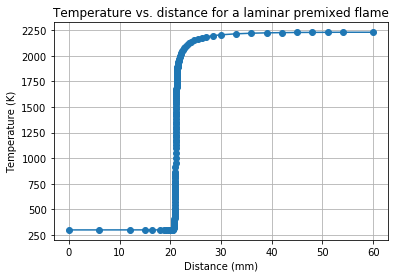

In [14]:
# plot the steady-state temperature profile
fig, ax = plt.subplots()
ax.plot(flame.grid*1000., flame.T, '-o', label='T')
ax.set(xlabel='Distance (mm)',
       ylabel='Temperature (K)',
       title ='Temperature vs. distance for a laminar premixed flame')
ax.grid(True)
#ax.legend(handlelength=4,loc='best')
fig.savefig("T_vs_x_LPF.pdf")

Note that the temperature gradient is close to zero at the inflow (left-hand) and at the outflow (right-hand) boundaries. It also can be seen (by the location of the symbols) that the computational grid is coarse near the boundaries, and is finer in the region of high temperature gradients. The extent of the region over which the temperature varies significantly is approximately 5 mm, and the steepest-temperature-gradient zone is limited to a region of approximately 1 mm in thickness. As we will see below, the region where most of the conversion from chemical to sensible enthalpy (heat release) occurs is even thinner.

It can be easily confirmed that the temperature at the right-hand boundary is equal (to within numerical solution tolerances) to the constant-pressure adiabatic flame temperature for the given reactant mixture thermochemical state. The temperature ratio across the flame is $T_b / T_u \approx 7.5 $. 

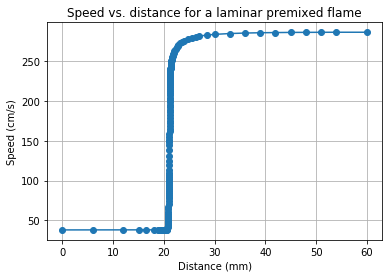

In [15]:
# plot the steady-state velocity profile
fig, ax = plt.subplots()
ax.plot(flame.grid*1000., flame.u*100., '-o', label='u')
ax.set(xlabel='Distance (mm)',
       ylabel='Speed (cm/s)',
       title ='Speed vs. distance for a laminar premixed flame')
ax.grid(True)
#ax.legend(handlelength=4,loc='best')
fig.savefig("u_vs_x_LPF.pdf")

The flow speed increases through the flame as the temperature increases and the mass density decreases, while the pressure remains constant. The product of the local mass density and the local flow speed is constant through the flame. We can confirm this as follows:

In [16]:
# compute the profile of mass density times flow speed through the flame
rhou = flame.density*flame.u

# print the result
rhou

array([0.42872916, 0.42872916, 0.42872916, 0.42872916, 0.42872916,
       0.42872916, 0.42872916, 0.42872916, 0.42872916, 0.42872916,
       0.42872916, 0.42872916, 0.42872916, 0.42872916, 0.42872916,
       0.42872916, 0.42872917, 0.42872918, 0.42872919, 0.42872919,
       0.42872919, 0.42872918, 0.42872916, 0.42872915, 0.42872913,
       0.42872911, 0.42872909, 0.42872907, 0.42872905, 0.42872904,
       0.42872903, 0.42872903, 0.42872903, 0.42872904, 0.42872903,
       0.42872905, 0.42872905, 0.42872907, 0.42872908, 0.4287291 ,
       0.42872911, 0.42872913, 0.42872914, 0.42872916, 0.42872917,
       0.42872919, 0.4287292 , 0.42872922, 0.42872924, 0.42872925,
       0.42872926, 0.42872926, 0.42872926, 0.42872925, 0.42872925,
       0.42872924, 0.42872923, 0.42872922, 0.42872921, 0.4287292 ,
       0.42872919, 0.42872918, 0.42872917, 0.42872916, 0.42872914,
       0.42872914, 0.42872913, 0.42872912, 0.42872911, 0.42872911,
       0.4287291 , 0.4287291 , 0.4287291 , 0.4287291 , 0.42872

The product of density times flow speed (the mass flux of mixture through the flame) is constant, to within at least six significant figures.

Next, let's look at species-mole-fraction profiles. These can be compared with Fig. 8.10 of Turns 4th ed.

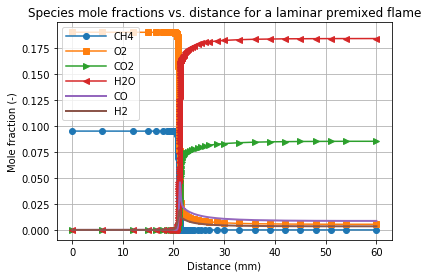

In [17]:
# plot steady-state major-species mole-fraction profiles, plus CO and H2
X_CH4 = flame.X[gas.species_index('CH4')]
X_O2  = flame.X[gas.species_index('O2')]
X_N2  = flame.X[gas.species_index('N2')]
X_CO2 = flame.X[gas.species_index('CO2')]
X_H2O = flame.X[gas.species_index('H2O')]
X_CO  = flame.X[gas.species_index('CO')]
X_H2  = flame.X[gas.species_index('H2')]

fig, ax = plt.subplots()
ax.plot(flame.grid*1000., X_CH4, '-o', label='CH4')
ax.plot(flame.grid*1000., X_O2,  '-s', label='O2')
#ax.plot(flame.grid*1000., X_N2,  '-s', label='N2') # leave out N2, so that other species can be seen more clearly
ax.plot(flame.grid*1000., X_CO2, '->', label='CO2')
ax.plot(flame.grid*1000., X_H2O, '-<', label='H2O')
ax.plot(flame.grid*1000., X_CO,        label='CO', lw=2)
ax.plot(flame.grid*1000., X_H2,        label='H2', lw=2)
ax.set(xlabel='Distance (mm)',
       ylabel='Mole fraction (-)',
       title ='Species mole fractions vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Xmajor_vs_x_LPF.pdf")

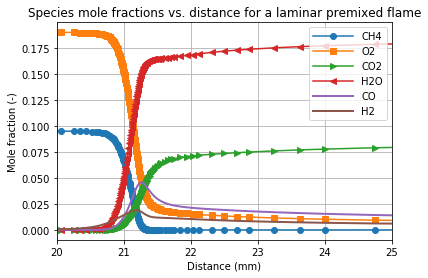

In [18]:
# zoom in to see more clearly what is happening in the main reaction zone
# the x limits may need to be changed to capture the flame zone, depending on the version of Cantera that you are using
fig, ax = plt.subplots()
ax.plot(flame.grid*1000., X_CH4, '-o', label='CH4')
ax.plot(flame.grid*1000., X_O2,  '-s', label='O2')
#ax.plot(flame.grid*1000., X_N2,  '-s', label='N2')
ax.plot(flame.grid*1000., X_CO2, '->', label='CO2')
ax.plot(flame.grid*1000., X_H2O, '-<', label='H2O')
ax.plot(flame.grid*1000., X_CO,        label='CO', lw=2)
ax.plot(flame.grid*1000., X_H2,        label='H2', lw=2)
ax.set(xlim=(20.,25.),
       xlabel='Distance (mm)',
       ylabel='Mole fraction (-)',
       title='Species mole fractions vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Xmajor_vs_x_LPF_zoom.pdf")

Most of the "action" in terms of major species disappearance or appearance occurs in a spatial region that is less than 1 mm thick. The appearance and subsequent reduction (to their equilibrium values) of CO and H2 as functions of $x$ can be seen.

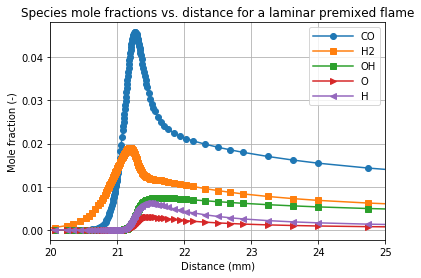

In [19]:
# plot steady-state minor-species mole fraction profiles
X_CO  = flame.X[gas.species_index('CO')]
X_H2  = flame.X[gas.species_index('H2')]
X_OH  = flame.X[gas.species_index('OH')]
X_O   = flame.X[gas.species_index('O')]
X_H   = flame.X[gas.species_index('H')]

fig, ax = plt.subplots()
ax.plot(flame.grid*1000., X_CO, '-o', label='CO')
ax.plot(flame.grid*1000., X_H2, '-s', label='H2')
ax.plot(flame.grid*1000., X_OH, '-s', label='OH')
ax.plot(flame.grid*1000., X_O,  '->', label='O' )
ax.plot(flame.grid*1000., X_H,  '-<', label='H' )
ax.set(xlim=(20.,25.),
       xlabel='Distance (mm)',
       ylabel='Mole fraction (-)',
       title ='Species mole fractions vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("Xminor_vs_x_LPF_zoom.pdf")

We could look at other intermediates, including hydrocarbon fragments, H2O2, CHO, etc. In general, the spatial sequence of appearance and disappearence of different species as functions of $x$ is qualitatively similar to the time sequence that we saw earlier in homogeneous reactors. 

Profiles of individual *species* net production rates $ \dot \omega _ i $ (kmol/m^3-s - see Figs. 8.11 and 8.12 of Turns 4th ed.) can be accessed using [`net_production_rates`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#cantera.FlameBase.net_production_rates), and profiles of individual *reaction* net rates of progress $q_i$ (kmol/m^3-s) can be accessed using [`net_rates_of_progress`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#cantera.FlameBase.net_rates_of_progress).

Finally, let's look at the heat-release-rate profile. This shows where the conversion from chemical (formation) enthalpy to sensible enthalpy (heat) takes place. We computed this manually in earlier tutorial Notebooks (e.g., 6_1_Ignition_delay), but here the attribute [`heat_release_rate`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#cantera.FlameBase.heat_release_rate) is available directly for a `FreeFlame()` and for other Cantera flame objects.

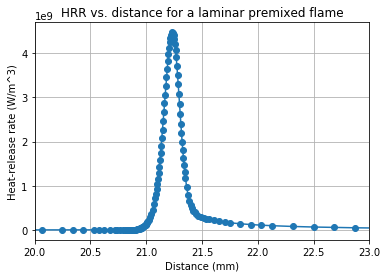

In [20]:
# plot the steady-state heat-release-rate profile
fig, ax = plt.subplots()
ax.plot(flame.grid*1000., flame.heat_release_rate, '-o', label='HRR')
ax.set(xlim=(20.,23.),
       xlabel='Distance (mm)',
       ylabel='Heat-release rate (W/m^3)',
       title ='HRR vs. distance for a laminar premixed flame')
ax.grid(True)
#ax.legend(handlelength=4,loc='best')
fig.savefig("HRR_vs_x_LPF_zoom.pdf")

The spatial extent of the region where most of the chemical activity takes place is a few tenths of a millimeter in thickness.

## 4. Parametric study: Laminar flame speed versus equivalence ratio

Here we will compute the laminar flame speed for CH4-air mixtures as a function of equivalence ratio, for a given reactant temperature and pressure, using gri30.cti. The results will be compared with those from a Metghalchi-and-Keck-like laminar flame speed correlation (see Chapter 8 of Turns 4th ed.).

In [21]:
# define a function that returns the laminar flame speed for a given reactant mixture state
# the gas mixture "gas" must be defined before calling this function
# here we suppress all output - this can be dangerous, if one is not confident that the solution will converge for all
#   cases of interest
# T_u is the unburned gas temperature (K)
# P is the constant pressure (Pa)
# fuel is the fuel desired, which must be available in "gas"
# air is the mixture of species corresponding to air, which must be defined before calling this function
# phi is the desired equivalence ratio
def gas_sl(T_u,P,fuel,air,phi):
    gas.TP = T_u, P
    gas.set_equivalence_ratio(phi,fuel,air)
    width = 0.015 # (m)
    flame = ct.FreeFlame(gas, width=width)
    flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)
    loglevel = 0
    flame.solve(loglevel=loglevel, auto=True)
    s_l = flame.u[0] # (m/s)
    return s_l

In [22]:
# specify the values of the equivalence ratio at which to compute the laminar flame speed
phis = [0.70, 0.80, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15, 1.20, 1.30, 1.40]

In [23]:
# compute the laminar flame speed for each equivalence ratio using the detailed reaction mechanism
# here the reactants are at ambient pressure and temperature, and are undiluted
fuel  = 'CH4'
air   = 'O2:1.0, N2:3.76'
T_u   = 300.
P     = ct.one_atm

# define an array to hold the computed laminar flame speed for each equivalence ratio
S_Lgas = np.zeros(np.size(phis))

# loop over the equivalence ratios, and compute the laminar flame speed for each equivalence ratio
# be patient - this may take a few minutes, depending on your computer
for i, phi in enumerate(phis):
    S_Lgas[i] = gas_sl(T_u,P,fuel,air,phi)
    print(i,phi,S_Lgas[i])

0 0.7 0.19590011410706343
1 0.8 0.2753593783744419
2 0.9 0.34201396404551115
3 0.95 0.3659159058994146
4 1.0 0.3819354261894096
5 1.05 0.38915848371296685
6 1.1 0.38537936546574775
7 1.15 0.36903749394620744
8 1.2 0.3386775678265775
9 1.3 0.23954014907726556
10 1.4 0.14082020105243145


In [24]:
# define another function that returns the laminar flame speed from a Metghalchi-and-Keck-based correlation
# here the parameters phi_M, B_M, and B_2 have been chosen to give good agreement with gri30.cti
#   for equivalence ratios close to phi_M, and on the lean side
def MetghalchiKeckCH4(T_u,P,Y_dil,phi):
    T_uref = 298.       # (K)
    P_ref  = ct.one_atm # (Pa)  
    phi_M  = 1.05       # (-) equivalence ratio at which the laminar flame speed has its maximum value
    B_M    = 38.4       # (cm/s) maximum laminar flame speed, for T_u=T_uref and P=P_ref and Y_dil=0
    B_2    = -150.      # (cm/s) rate of falloff of laminar flame speed away from phi_M
    
    S_Lref = B_M + B_2*( phi - phi_M )**2
    gamma  =  2.18 - 0.8 *( phi - 1. )
    beta   = -0.16 + 0.22*( phi - 1. )
    
    S_L    = S_Lref*(T_u/T_uref)**gamma*(P/P_ref)**beta*( 1. - 2.1*Y_dil ) / 100. # (m/s)
    
    return S_L

In [25]:
# compute the laminar flame speed for each equivalence ratio using the flame-speed correlation
# here the reactants are at ambient pressure and temperature, and are undiluted
T_u   = 300. # (k)
P     = ct.one_atm # (Pa)
Y_dil = 0. # this is included because it is needed for the flame-speed correlation

# define an array to hold the computed laminar flame speed for each equivalence ratio
S_Lmk = np.zeros(np.size(phis))

# loop over the equivalence ratios, and compute the laminar flame speed for each equivalence ratio
for i, phi in enumerate(phis):
    S_Lmk[i] = MetghalchiKeckCH4(T_u,P,Y_dil, phi)
    print(i,phi,S_Lmk[i])

0 0.7 0.20351789502828166
1 0.8 0.2948288011663261
2 0.9 0.3555849921469353
3 0.95 0.37452037139841293
4 1.0 0.38583542764846973
5 1.05 0.3895362726765599
6 1.1 0.3856290149927718
7 1.15 0.3741197598392869
8 1.2 0.35501460919183536
9 1.3 0.2940410129944382
10 1.4 0.20275697693273834


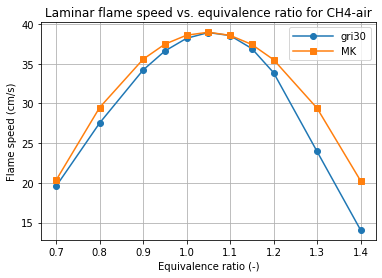

In [26]:
# plot laminar flame speeds versus equivalence ratio
fig, ax = plt.subplots()
ax.plot(phis , S_Lgas*100., '-o', label='gri30')
ax.plot(phis , S_Lmk*100.,  '-s', label='MK')
ax.set(xlabel='Equivalence ratio (-)',
       ylabel='Flame speed (cm/s)',
       title ='Laminar flame speed vs. equivalence ratio for CH4-air')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("S_L_vs_phi.pdf")

Note that the peak value of the laminar flame speed corresponds to a slightly fuel-rich mixture, as discussed in Chapter 8.

It is emphasized that here, the parameters in the flame-speed correlation have been selected to ensure good agreement with the detailed mechanism for equivalence ratios that correspond to the peak flame speed, and for ambient-temperature-and-pressure undiluted reactants.

The Metghalchi and Keck correlation gives a flame speed that decreases from its maximum value quadratically with equivalence ratio, and symmetrically on the fuel-rich side and the fuel-lean side. Within this framework, it is usually not possible to specify a single set of parameters that works equally well on the fuel-lean side and on the fuel-rich side. Here the agreement is somewhat better on the fuel-lean side.

## 5. What's next

In subsequent tutorial Notebooks, the sensitivity of computed flame speeds and flame structure to variations in the chemical mechanism and in the molecular transport model will be explored.

Other Cantera flame objects that can be used for premixed laminar flames in other configurations are [`BurnerFlame`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#burnerflame) and [`CounterflowPremixedFlame`]( https://cantera.org/documentation/docs-2.4/sphinx/html/cython/onedim.html#counterflowpremixedflame).